# Script to reproduce Nature 445, 515-518
The system can be discribed by the Hamiltonian (in strong dispersive regime, under rotating frame and with RWA) and a set of collapse operators: 
$$
\begin{align}
H &= H_0 - H_R + H_{rf} + H_s \\
H_0 &= \omega_r (a^\dagger a + 1/2) + \omega_q \sigma_z/2 + \chi (a^\dagger a + 1/2)\sigma_z \\
H_R &= \omega_rf a^\dagger a + \omega_s \sigma_z/2 \\
H_{rf} &= \epsilon_{rf}(a+a^\dagger) \\
H_s &= (g/\Delta)\epsilon_s  (\sigma^+ + \sigma^-) \\
C_n &\in \{\sqrt{\kappa(1+n_{th})} a, \sqrt{\kappa n_{th}} a^\dagger, \sqrt{\gamma}\sigma^-, \sqrt{\gamma_\phi}\sigma_z\}
\end{align}
$$

The master equation: 
$$
\dot\rho = -i[\rho, H] + \frac 12 \sum_n \big(2C_n\rho C_n^\dagger - \{\rho, C_n^\dagger C_n\}\big)
$$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

In [3]:
# The constants parameters used
# All the units are MHz
wr = 5.7E3 * 2 * np.pi    # resonator frequency
wq = 6.95E3 * 2 * np.pi   # qubit frequency
chi = -17 * np.pi         # parameter in the dispersive hamiltonian

kappa = 0.25 * 2 * np.pi  # damping rate for cavity
gamma = 1.8 * 2 * np.pi   # relaxation rate for qubit (1/T1)
gammap = 1.0 * 2 * np.pi  # dephasing rate for qubit (1/T2)

Delta = np.abs(wr - wq)    # detuning
g = np.sqrt(-Delta * chi)  # coupling strength that is consistent with chi

In [4]:
# compare detuning and g, the first should be much larger than the second
Delta/(2*np.pi), g/(2*np.pi)

(1250.0000000000007, 103.07764064044154)

In [4]:
# The operators we are going to use
N = 20 # The truncate 
# cavity operators
a = tensor(destroy(N), qeye(2))
nc = a.dag() * a
# xc = a + a.dag()

# atomic operators
sp = tensor(qeye(N), destroy(2)) # simga^+
sm = sp.dag()                    # sigma^-
sz = tensor(qeye(N), sigmaz()) 
sx = tensor(qeye(N), sigmax())
# nq = sm.dag() * sm
# xq = sm + sm.dag() = sx

I = tensor(qeye(N), qeye(2))

# collapse operators
def c_ops(nth = 0.1): 
    return [np.sqrt(kappa*(1+nth)) * a, 
    np.sqrt(kappa*nth) * a.dag(), # damping for cavity
    np.sqrt(gamma) * sm,     # relaxation for qubit
    np.sqrt(gammap) * sz]    # dephasing for qubit

# dispersive hamiltonian
H0 = wr * (a.dag() * a + I/2.0) + (wq / 2.0) * sz + \
    chi * (a.dag() * a + I/2) * sz
delta = 2.0 * 2 * np.pi 
wrf0 = wr - chi + delta    # RF freq (pumping) .... 
# rotating frame diff
def Hr(ws, wrf = wrf0): 
    return wrf * a.dag() * a + (ws / 2.0) * sz

## Photon number distribution
Before going any futher, we want to check if the truncate is valid, by checking the photon number distribution. 

The following codes get photon number distribution for $\epsilon_{rf} = 30$ MHz by ploting the diagonal elements of $\mathrm{Tr}_q \rho$ with $\rho$ being the steady state density matrix.

In [5]:
def cavity(erf, wrf=wrf0): 
    """
    Return the steady state of the system
    without any sweaping signals /or qubit at ground state. 
    erf: The strength of RF signal (driving for cavity)
    wrf: The frequency of RF signal
    """
    Hrf = erf * (a + a.dag())
    H = H0 - Hr(0.0, wrf) + Hrf 
    rhoss = steadystate(H, c_ops()) 
    return rhoss

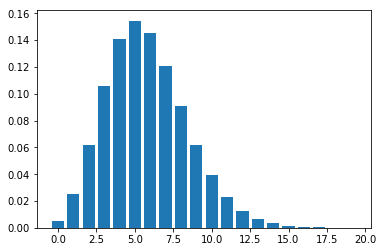

In [13]:
rhoc = cavity(30, wrf0).ptrace(0)
plt.bar(np.arange(0, N), rhoc.diag())
plt.show()

From the above, we can see that photon number near/over 20 has extremely small probabilities: the truncate is valid. 

## Average photon number
The following calculate average photon number $\langle a^\dagger a\rangle$ v.s. $\epsilon_{rf}$ and $\omega_{rf}$. This part should be calculated analytically. 

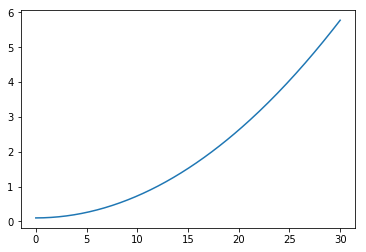

In [14]:
erflist = np.linspace(0, 30, 200)
nbarlist = [expect(a.dag()*a, cavity(erf, wrf0)) for erf in erflist]
plt.plot(erflist, nbarlist)
plt.show()

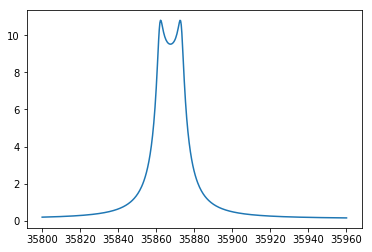

In [15]:
# wrflist = np.linspace(wr+chi+delta-20, wr-chi+delta+20, 100)
wrflist = wrf0 + np.linspace(-80, 80, 500)
nbarlist = [expect(a.dag()*a, cavity(20, wrf)) for wrf in wrflist]
plt.plot(wrflist, nbarlist)
plt.show()
# at resonance the trumcate does not work well

Note that the weired downwards curve on resonance is the result of breaking of truncate: when it's on resonance, average photon number becomes large, so the truncate is no longer valid. 

## Sweaping signal result

In [6]:
def with_sweaping(erf, ws, esp=0.1):
    """
    Return the steady state of the system with sweaping signals.
    erf: The strength of RF signal (driving for cavity)
    ws: The frequency of the sweaping signal
    esp: The strength of the sweaping signal (in our case, it's small
            so that the qubit is approximately at ground state)
    """
    Hrf = erf * (a + a.dag())
    Hsp = esp * (g/Delta) * sx
    rhoss = steadystate(H0 - Hr(ws) + Hrf + Hsp, c_ops()) 
    return rhoss

In [7]:
wslist = 2 * np.pi * np.linspace(6.75E3, 7.0E3, 500)

Note that we are measuring the reduction of transmitted amplitude. The transmitted amplitude is $\left|\langle a + a^\dagger\rangle\right|^2$

Ibar=0.006283, nbar=0.001577


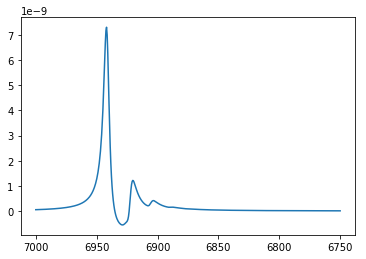

In [22]:
erf = 0.5 # This quantity varies
rho_non_sw = cavity(erf)
Ibar = (expect(a.dag() + a, rho_non_sw))**2 
nbar = (expect(a.dag() * a, rho_non_sw)) - 0.1 # 0.1 is default n_th
print("Ibar=%f, nbar=%f"%(Ibar,nbar))
trans = np.array([
    expect(a.dag() + a, with_sweaping(erf, w, 0.1)) 
    for w in wslist]) 
plt.plot(wslist/(2*np.pi),  Ibar - trans**2 )
plt.gca().invert_xaxis()
plt.show()

For small average photon number, when the signal is at the middle of  two peak, we do not have reduction of transmission strength but an increasing. This unexpected result may come from an interference strengthing of two modes. 

## Further attampt
Check the difference of average photon number with/out sweaping signals

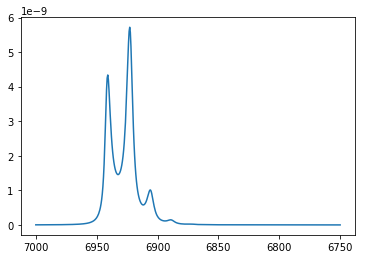

In [8]:
erf = 0.5 # This quantity varies
nbar_diff = np.array([
    expect(a.dag() * a, with_sweaping(erf, w, 0.1)) 
    for w in wslist]) - expect(a.dag() * a, cavity(erf))
plt.plot(wslist/(2*np.pi),  nbar_diff )
plt.gca().invert_xaxis()
plt.show()

The weird thing is that with smaller transmission at the peak, we have greater photon number. To find out what happened, it is also meaningful to check the difference of photon number at one peak and at the abnormally strengthing between two peak. 

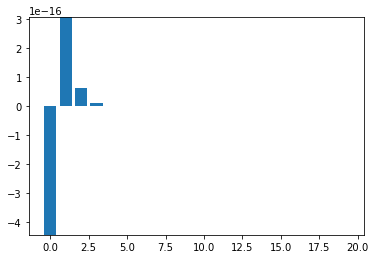

In [19]:
photon_no_sw = cavity(erf).ptrace(0)
photon_sw1 = with_sweaping(erf, 6942, 0.1).ptrace(0) # at n=0 peak
plt.bar(np.arange(N), photon_sw1.diag() - photon_no_sw.diag())
plt.show()

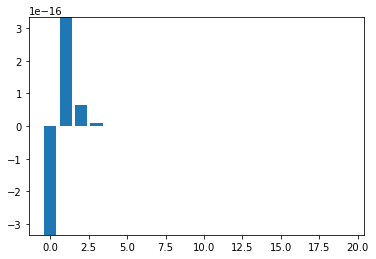

In [20]:
photon_sw2 = with_sweaping(erf, 6929, 0.1).ptrace(0) # between two peak
plt.bar(np.arange(N), photon_sw2.diag() - photon_no_sw.diag())
plt.show()

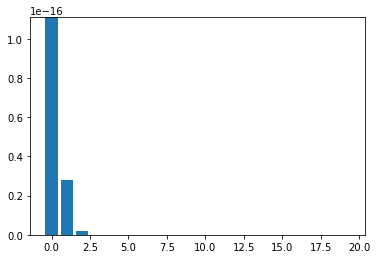

In [22]:
plt.bar(np.arange(N), photon_sw2.diag() - photon_sw1.diag())
plt.show()